In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.signal
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
obs_rate = 100

def load_file(filename):
    phase = np.fromfile(filename, dtype = 'float32').astype('double')
    start = np.datetime64(filename.strip('.f32').split('_')[-1])
    timestamps = start + np.timedelta64(1, 'ns') * np.arange(phase.shape[0]) * 1e9 / obs_rate
    return xr.Dataset({'phase' : ('time', np.unwrap(phase))}, coords = {'time' : timestamps})

It seems that the DF9NP GPSDO lost lock shortly after 2019-11-20T04:57:30. We exclude the measurements after this moment.

In [3]:
data = load_file('gpsdo_phase_2019-11-17T21:55:29.989819.f32').sel(time = slice('2019-11-17T21:55:31', '2019-11-20T04:57:30'))

In [4]:
(data.coords['time'][-1] - data.coords['time'][0]).astype('float')*1e-9

<xarray.DataArray 'time' ()>
array(198119.99)

In [5]:
residual_freq = np.polyfit((data.coords['time'] - data.coords['time'][0]).astype('float') * 1e-9, data['phase'], 1)[0]/(2*np.pi)
residual_freq

0.00016838241157320297

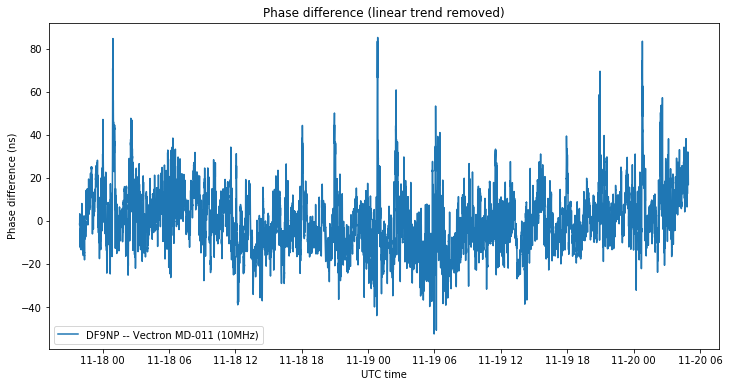

In [6]:
f_obs = 10e6
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(data.coords['time'][::100], scipy.signal.detrend(data['phase'][::100]/(2*np.pi*f_obs)*1e9))
plt.title('Phase difference (linear trend removed)')
plt.ylabel('Phase difference (ns)')
plt.xlabel('UTC time')
plt.legend(['DF9NP -- Vectron MD-011 (10MHz)']);

In [7]:
def adev(series, skip, freq = 10e9, overlapping = False):
    x = series.values/(2*np.pi*freq)
    
    tau = skip / obs_rate
    if overlapping:
        y = x[:-2*skip] - 2*x[skip:-skip] + x[2*skip:]
    else:
        z = x[:x.size//skip*skip].reshape((-1,skip))[:,0]
        y = z[:-2] - 2*z[1:-1] + z[2:]
    return np.sqrt(0.5/tau**2*np.average(y**2))

def get_skips(n):
    if n <= 0:
        return np.array([], dtype = 'int')
    a = int(np.log10(n))
    step = max(10**(a-2), 1)
    return np.concatenate((get_skips(10**a - 1) , np.arange(10**a, n+1, step)))

def compute_adev(data, overlapping = False):
    skips = get_skips(data.coords['time'].size//2)
    taus = skips / obs_rate
    adevs = [adev(data['phase'], skip, f_obs, overlapping) for skip in skips]
    return xr.Dataset({'adev' : ('tau', adevs)}, coords = {'tau' : taus})

Recompute Allan deviations (takes several minutes)

In [8]:
# adevs = compute_adev(data, overlapping = True)
# adevs.to_netcdf('adevs_df9np_vectron.nc')

In [9]:
adevs = xr.open_dataset('adevs_df9np_vectron.nc')
adevs_qo100 = xr.open_dataset('adevs_evening2_qo100.nc')

In [10]:
def plot_adev(a, label):
    plt.loglog(a.coords['tau'], a['adev'], label = f'{label}')

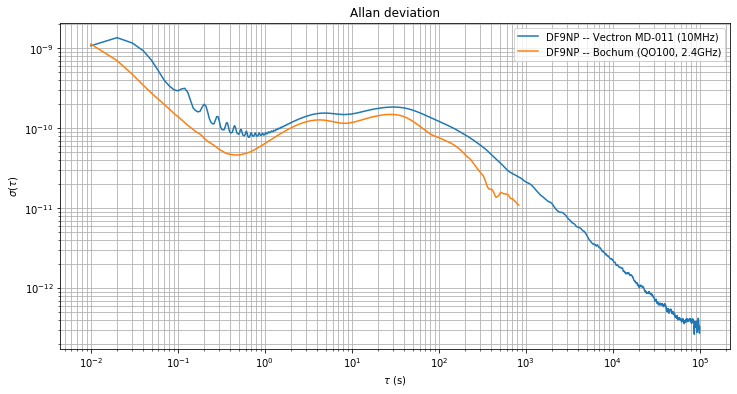

In [11]:
plt.figure(figsize = (12,6), facecolor = 'w')
plot_adev(adevs, 'DF9NP -- Vectron MD-011 (10MHz)')
plt.loglog(adevs_qo100.coords['tau'], adevs_qo100['CW-BPSK'], label = 'DF9NP -- Bochum (QO100, 2.4GHz)')
plt.xlabel('$\\tau$ (s)')
plt.ylabel('$\\sigma(\\tau)$')
plt.legend()
plt.grid(which = 'both')
plt.title('Allan deviation');